In [32]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [35]:
import pandas as pd
import numpy as np
from sklearn.datasets import make_classification
from sklearn import model_selection
from sklearn import ensemble
from sklearn import metrics


x, y = make_classification(n_samples=150, n_features=15, weights=[0.25, 0.75], random_state=12)

In [36]:
# label counts
np.unique(y, return_counts=True)

(array([0, 1]), array([ 38, 112]))

In [28]:
%%time
clf = ensemble.RandomForestClassifier(n_jobs=-1)
# GridSearchCV
param_grid = {
    "n_estimators": [100,200,250,300,400,500],
    "max_depth": [1,2,5,7,11,15],
    "criterion": ["gini", "entropy"]
}

model = model_selection.GridSearchCV(
    estimator=clf, 
    param_grid=param_grid, 
    scoring="accuracy", 
    verbose=10,
    n_jobs=-1,
    cv=3
)

model.fit(x, y)

print(f"Best Score: {model.best_score_}")
print(f"Best params: {model.best_params_}")

Fitting 3 folds for each of 72 candidates, totalling 216 fits
Best Score: 0.9333333333333332
Best params: {'criterion': 'gini', 'max_depth': 11, 'n_estimators': 100}
CPU times: user 758 ms, sys: 81.3 ms, total: 839 ms
Wall time: 1min 22s


In [29]:
%%time
# RandomSearchCV
clf = ensemble.RandomForestClassifier(n_jobs=-1)
param_grid = {
    "n_estimators": np.arange(100,1500,100),
    "max_depth": np.arange(1,31),
    "criterion": ["gini", "entropy"]
}

model = model_selection.RandomizedSearchCV(
    estimator=clf,
    param_distributions=param_grid,
    n_iter=15,
    scoring="accuracy",
    verbose=10,
    n_jobs=-1,
    cv=5
)

model.fit(x, y)

print(f"Best Score: {model.best_score_}")
print(f"Best params: {model.best_params_}")

Fitting 5 folds for each of 15 candidates, totalling 75 fits
Best Score: 0.9199999999999999
Best params: {'n_estimators': 900, 'max_depth': 13, 'criterion': 'gini'}
CPU times: user 2.55 s, sys: 409 ms, total: 2.96 s
Wall time: 1min 12s


In [45]:
%%time
# Bayesian optimization with gaussian process

from functools import partial
from skopt import gp_minimize, space

def optimize(params, param_names, x, y):
    params = dict(zip(param_names, params))
    model = ensemble.RandomForestClassifier(**params)
    
    kf = model_selection.StratifiedKFold(n_splits=5)
    accuricies = []
    for train_idx, val_idx in kf.split(X=x, y=y):
        x_train = x[train_idx, :]
        y_train = y[train_idx]
        x_val = x[val_idx, :]
        y_val = y[val_idx]
        
        model.fit(x_train, y_train)
        preds = model.predict(x_val)
        acc = metrics.accuracy_score(y_val, preds)
        accuricies.append(acc)
        
        return -1*np.mean(accuricies)

    
param_space = [
    space.Integer(3, 15, name="max_depth"),
    space.Integer(100, 1500, name="n_estimators"),
    space.Categorical(["gini", "entropy"], name="criterion"),
    space.Real(0.01, 1, prior="uniform", name="max_features"),
]

param_names = ["max_depth", "n_estimators", "criterion", "max_features"]

optimization_func = partial(optimize, param_names=param_names, x=x, y=y)
result = gp_minimize(optimization_func, dimensions=param_space, n_calls=10, n_random_starts=5, verbose=10)

best_params = dict(zip(param_names, result.x))
print(best_params)


Iteration No: 1 started. Evaluating function at random point.
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 1.7162
Function value obtained: -0.9333
Current minimum: -0.9333
Iteration No: 2 started. Evaluating function at random point.
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 1.2439
Function value obtained: -1.0000
Current minimum: -1.0000
Iteration No: 3 started. Evaluating function at random point.
Iteration No: 3 ended. Evaluation done at random point.
Time taken: 1.7000
Function value obtained: -1.0000
Current minimum: -1.0000
Iteration No: 4 started. Evaluating function at random point.
Iteration No: 4 ended. Evaluation done at random point.
Time taken: 1.7464
Function value obtained: -1.0000
Current minimum: -1.0000
Iteration No: 5 started. Evaluating function at random point.
Iteration No: 5 ended. Evaluation done at random point.
Time taken: 2.4694
Function value obtained: -0.9667
Current minimum: -1.0000
Iteration No: 6 started. 

<AxesSubplot:title={'center':'Convergence plot'}, xlabel='Number of calls $n$', ylabel='$\\min f(x)$ after $n$ calls'>

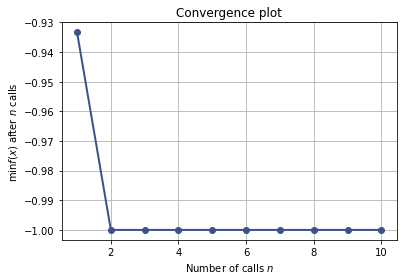

In [46]:
from skopt.plots import plot_convergence
plot_convergence(result)

In [49]:
# %%time
# #Tree structured Parzen Estimator

# from hyperopt import hp, fmin, tpe, Trials
# from hyperopt.pyll.base import scope

# param_space = {
#     "max_depth": scope.int(hp.uniform("max_depth", 1, 15, 1)),
#     "n_estimators": scope.int(hp.uniform("n_estimators", 100, 1500, 1)),
#     "criterion": hp.choice("criterion", ["gini", "entropy"]),
#     "max_features": hp.uniform("max_features", 0, 1)
# }

# optimization_func = partial(optimize, x=x, y=y)
# trials = Trials()

# hopt = fmin(fn=optimization_func, space=param_space, algo=tpe.suggest, max_evals=10, trials=trials)
# print(hopt)